# Installing dependencies and libraries

In [ ]:
# Install dependencies
!apt install tesseract-ocr
!pip install pymupdf pytesseract opencv-python pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 54.3 MB/s eta 0:00:00


In [ ]:
# Install libraries
import fitz  # PyMuPDF
import cv2
from PIL import Image

import pytesseract
from pytesseract import Output
import unicodedata, re

from decimal import Decimal
from dateutil import parser as dateparser

import numpy as np
import pandas as pd
import json

In [ ]:
# Load scanned PDF document
from google.colab import files

uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]  # Get uploaded file name

# Open the scanned mortgage document
doc = fitz.open(pdf_path)

Saving MTG_10009588.pdf to MTG_10009588.pdf


In [ ]:
# Attempt extracting text for ONE PAGE ONLY WITHOUT OCR
page = doc[0]
text = page.get_text("text")  # Normal text extraction
print("Extracted Text:", text)  # Expecting empty or incorrect output

Extracted Text: 


# Use Tesseract OCR to extract text from the scanned mortgage document.

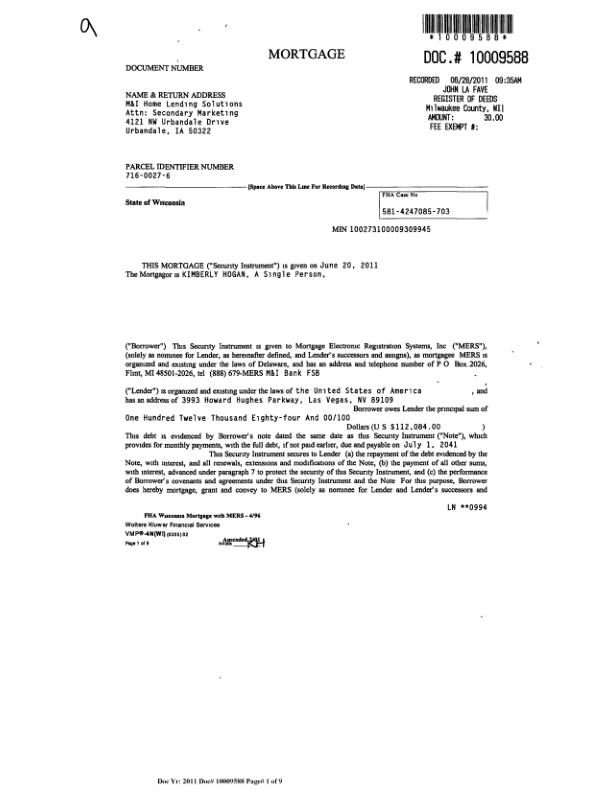

In [ ]:
# Convert PDF to Image for OCR compatibility

pix = page.get_pixmap()
# page.get_pixmap() (from PyMuPDF / fitz) renders the PDF page into a pixmap (basically, a raster image in memory).
# A pixmap stores the pixel samples (color values) of the page at a given resolution.
# Attributes include:
# 1. pix.width → width in pixels
# 2. pix.height → height in pixels
# 3. pix.samples → the raw byte data of all pixels

img = np.array(Image.frombytes("RGB", [pix.width, pix.height], pix.samples))
# Image.frombytes() is from PIL (Pillow).
# It reconstructs an image from raw pixel data:
# "RGB" means each pixel has 3 color channels (red, green, blue).
# [pix.width, pix.height] specifies the size of the image.
# pix.samples provides the actual pixel values in bytes.
# At this point, you have a PIL Image.

display(Image.fromarray(img))

# Pre-process image for better OCR recognition

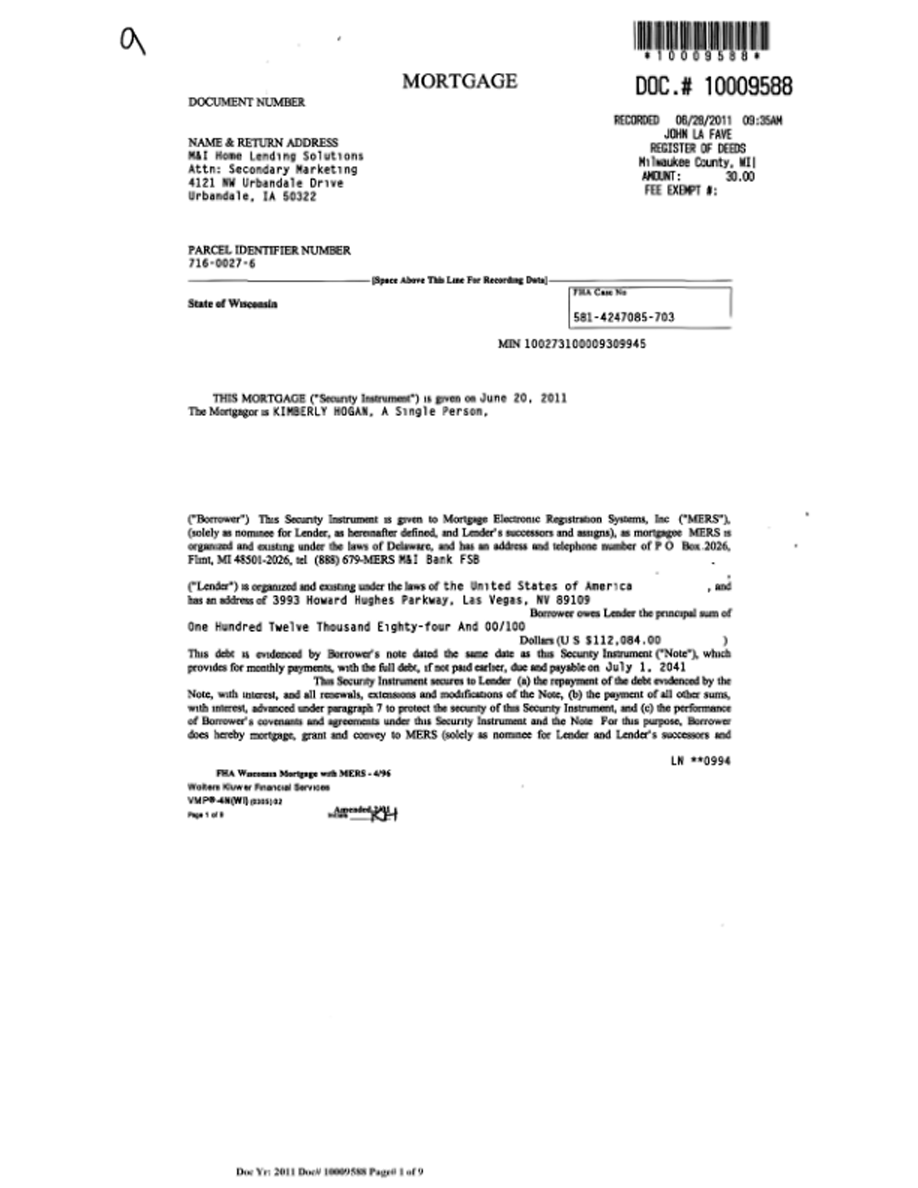

In [ ]:
# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# gray

# Try CLAHE (local contrast enhancement – better for documents)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
eq = clahe.apply(gray)
# eq

# Light denoising: Remove speckles but keep sharp edges of text.
denoised = cv2.fastNlMeansDenoising(eq, None, h=10, templateWindowSize=7, searchWindowSize=21)
# denoised

# Upscale for OCR: OCR engines read small text better if you enlarge the input.
scaled = cv2.resize(denoised, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

# Display the enhanced image
display(Image.fromarray(scaled))

# Use image pre-processing techniques, fix formatting issues and correct OCR misreads, and bounding boxes to identify and localize key information, such as party names, amounts, dates, and property location -> for ALL pages

In [ ]:
# Import libraries
import re, json, unicodedata
import pandas as pd
from decimal import Decimal
from dateutil import parser as dateparser
from pytesseract import Output

# Targets: patterns you want to localize (party names, amounts, dates, address)
# We'll search these per page and attach bboxes from word-level OCR.
results = {
    "Document Title": [],
    "Borrower": [],
    "Lender": [],
    "Loan Amount": [],
    "Recording Date": [],
    "Loan Date": [],
    "Property Address": []
}

# Loop over all pages
for pi in range(len(doc)):
    page = doc[pi]

    # --- Render & preprocess ---
    pix  = page.get_pixmap(dpi=400, alpha=False)  # render bigger instead of post-upscale
    img  = np.frombuffer(pix.samples, np.uint8).reshape(pix.height, pix.width, pix.n)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(2.0,(8,8))
    eq = clahe.apply(gray)
    denoised = cv2.fastNlMeansDenoising(eq, None, h=10, templateWindowSize=7, searchWindowSize=21)
    scaled = cv2.resize(denoised, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

    # --- OCR plain text + word boxes -----------------------------------------------------------------
    config = "--oem 1 --psm 4"
    raw_text = pytesseract.image_to_string(scaled, config=config, lang="eng")
    data = pytesseract.image_to_data(scaled, config=config, lang="eng", output_type=Output.DATAFRAME)

    # Keep only rows with valid confidence, non-empty text, and not just blanks
    df = data[(data.conf.notna()) & (data.text.notna()) & (data.text.str.strip()!="")].copy()

    # Compute top-left x coordinate
    df["x1"] = df["left"]

    # Compute top-left y coordinate
    df["y1"] = df["top"]

    # Compute bottom-right x coordinate
    df["x2"] = df["left"] + df["width"]

    # Compute bottom-right y coordinate
    df["y2"] = df["top"] + df["height"]

    # Ensure text column is string type (safe for regex and further processing)
    df["text"] = df["text"].astype(str)

    # Normalize Unicode characters (e.g., curly quotes → straight quotes, ligatures → letters)
    t = unicodedata.normalize("NFKC", raw_text)

    # Replace en-dash and em-dash with hyphen; curly quotes with straight quotes
    t = (t.replace("–","-").replace("—","-")
       .replace("’","'").replace("“","\"").replace("”","\""))

    # Fix words split with hyphen at line breaks (e.g., "ELECTRON-\nIC" → "ELECTRONIC")
    t = re.sub(r"(\w)-\s*\n\s*(\w)", r"\1\2", t)

    # Collapse weird whitespace characters (tabs, formfeeds, etc.) into a single space
    t = re.sub(r"[ \t\r\f\v]+", " ", t)

    # Prevent words from merging across newlines (e.g., "Mortgage\nFSB" → "Mortgage FSB")
    t = re.sub(r"(\S)\n(\S)", r"\1 \2", t)

    # Collapse multiple spaces into one and strip leading/trailing whitespace
    t = re.sub(r" {2,}", " ", t).strip()

    # Correct money misreads: OCR often sees "$" as "S" or "§" (e.g., "S112,084" → "$112,084")
    t = re.sub(r"(?<!\w)[S§]\s*(\d)", r"$\1", t)

    # Fix common digit errors: letter "O" → zero, lowercase "l" → one
    t = t.replace("O","0").replace("l","1")
    # ------------------------------------------------------------------------------

    # --- Build line strings from word boxes (so we can map regex spans -> bbox) ----
    # High-level overview:
    # This groups OCR words into full text lines, reconstructs the line text,
    # calculates a bounding box that covers the entire line,
    # and tracks character spans so regex matches in the line
    # can later be mapped back to the exact word bounding boxes.
    group_cols = ["block_num","par_num","line_num"]
    line_rows = []
    for _, g in df.groupby(group_cols, dropna=False):
        g = g.sort_values("word_num")
        line_text = " ".join(g.text.tolist())
        bbox = [int(g.x1.min()), int(g.y1.min()), int(g.x2.max()), int(g.y2.max())]
        spans, pos = [], 0
        for w in g.text.tolist():
            spans.append((pos, pos+len(w)))
            pos += len(w) + 1
        line_rows.append({
            "text": line_text,
            "bbox": bbox,
            "words": g[["text","x1","y1","x2","y2"]].to_numpy(),
            "spans": spans
        })

    # --------------------------------------------------------------------------------

    # --- Patterns & In-Line Extraction (value + bbox) ---
    # 1) Document Title
    '''
    What it does:
    1. Looks for a title keyword like MORTGAGE, DEED OF TRUST, or DEED in each reconstructed line.
    2. When it finds a match, it maps the regex match back to the specific words in that line (using the precomputed character spans),
    unions those words’ bounding boxes, and stores:
              - page (1-based),
              - value (e.g., "Mortgage"),
              - bbox (the union rectangle).
    3. Stops after the first title match on that page.

    Why: Titles are typically prominent and appear once per page; unioning matched words gives a tight, accurate box.
    '''

    pat = re.compile(r"\b(MORTGAGE|DEED OF TRUST|DEED)\b", re.I)
    for L in line_rows:
        m = pat.search(L["text"])
        if m:
            # union word boxes overlapping the match
            s,e = m.span(); spans=[]
            for (w,(a,b)) in zip(L["words"], L["spans"]):
                if s < b and e > a:
                    spans.append([int(w[1]), int(w[2]), int(w[3]), int(w[4])])
            if spans:
                xs1, ys1, xs2, ys2 = zip(*spans)
                results["Document Title"].append({
                    "page": pi+1,
                    "value": m.group(1).title(),
                    "bbox": [min(xs1), min(ys1), max(xs2), max(ys2)]
                })
            break

    # 2) Recording Date (e.g., RECORDED mm/dd/yyyy)
    '''
    What it does:
    1. Searches for a pattern like RECORDED mm/dd/yyyy in each line.
    2. On a match, it converts the captured date to ISO format (YYYY-MM-DD) when possible,
    then unions the matched words’ boxes to get a bounding rectangle.
    3. Saves page, ISO value, and bbox, then stops after the first match.

    Why: Recording dates often use mm/dd/yyyy and appear near a “RECORDED” label; converting to ISO standardizes downstream usage.
    '''
    pat = re.compile(r"\bRECORDED\b.*?(\d{1,2}/\d{1,2}/\d{2,4})", re.I)
    for L in line_rows:
        m = pat.search(L["text"])
        if m:
            s,e = m.span(); spans=[]
            for (w,(a,b)) in zip(L["words"], L["spans"]):
                if s < b and e > a:
                    spans.append([int(w[1]), int(w[2]), int(w[3]), int(w[4])])
            if spans:
                xs1, ys1, xs2, ys2 = zip(*spans)
                try:
                    iso = dateparser.parse(m.group(1)).date().isoformat()
                except:
                    iso = m.group(1)
                results["Recording Date"].append({
                    "page": pi+1,
                    "value": iso,
                    "bbox": [min(xs1), min(ys1), max(xs2), max(ys2)]
                })
            break

    # 3) Loan Date (e.g., "given on June 20, 2011")
    '''
    What it does:
    1. Looks for phrasing like given on June 20, 2011.
    2. If found, parses the date to ISO format when possible.
    3. Computes the union of boxes for the matched words and stores page, value, bbox.
    4. Stops at the first match.

    Why: Loan date phrasing tends to be consistent; parsing to ISO ensures uniform output.
    '''
    pat = re.compile(r"\bgiven on\s+([A-Za-z]{3,9}\s+\d{1,2},\s*\d{4})", re.I)
    for L in line_rows:
        m = pat.search(L["text"])
        if m:
            s,e = m.span(); spans=[]
            for (w,(a,b)) in zip(L["words"], L["spans"]):
                if s < b and e > a:
                    spans.append([int(w[1]), int(w[2]), int(w[3]), int(w[4])])
            if spans:
                xs1, ys1, xs2, ys2 = zip(*spans)
                try:
                    iso = dateparser.parse(m.group(1)).date().isoformat()
                except:
                    iso = m.group(1)
                results["Loan Date"].append({
                    "page": pi+1,
                    "value": iso,
                    "bbox": [min(xs1), min(ys1), max(xs2), max(ys2)]
                })
            break

    # 4) Borrower (Mortgagor is <NAME>[,/.])
    '''
    What it does:
    1. Searches for Mortgagor is <NAME> pattern.
    2. Takes the captured name, cleans it (remove stray non-name chars, normalize spacing, title-case).
    3. Unions the boxes of the matching words, then stores page, cleaned value, and bbox.
    4. Stops at the first match.

    Why: Borrower names can include punctuation or qualifiers—light cleanup yields a neat, canonical name while the bbox localizes it precisely.
    '''
    pat = re.compile(r"\bMortgagor\s+is\s+(.+?)(?:,|\.)", re.I)
    for L in line_rows:
        m = pat.search(L["text"])
        if m:
            raw_name = m.group(1)
            cleaned = re.sub(r"[^A-Za-z '\.-]", " ", raw_name).strip()
            cleaned = " ".join(w.capitalize() for w in cleaned.split())
            s,e = m.span(); spans=[]
            for (w,(a,b)) in zip(L["words"], L["spans"]):
                if s < b and e > a:
                    spans.append([int(w[1]), int(w[2]), int(w[3]), int(w[4])])
            if spans:
                xs1, ys1, xs2, ys2 = zip(*spans)
                results["Borrower"].append({
                    "page": pi+1,
                    "value": cleaned,
                    "bbox": [min(xs1), min(ys1), max(xs2), max(ys2)]
                })
            break

    # 5) Lender (Lender is <NAME>[,/.]) or bank-name fallback
    '''
    What it does:
    1. First tries to match Lender is <NAME> and, if found, records page, cleaned value, and bbox (union of matched words).
    2. If that pattern is not found, it falls back to a list of common bank names (e.g., M&I Bank FSB, U.S. Bank, etc.).
    3. As soon as one match (primary or fallback) is found, it records and stops.

    Why: Lender language varies across forms; the fallback ensures you still pick up named banks even if the “Lender is …” phrasing isn’t present.
    '''
    pat = re.compile(r"\bLender\s+is\s+(.+?)(?:,|\.)", re.I)
    lender_done = False

    # Primary method
    for L in line_rows:
        m = pat.search(L["text"])
        if m:
            cleaned = m.group(1).strip()
            s,e = m.span(); spans=[]
            for (w,(a,b)) in zip(L["words"], L["spans"]):
                if s < b and e > a:
                    spans.append([int(w[1]), int(w[2]), int(w[3]), int(w[4])])
            if spans:
                xs1, ys1, xs2, ys2 = zip(*spans)
                results["Lender"].append({
                    "page": pi+1,
                    "value": cleaned,
                    "bbox": [min(xs1), min(ys1), max(xs2), max(ys2)]
                })
                lender_done = True
                break

    # Fallback method
    if not lender_done:
        pat2 = re.compile(r"\b(M&I\s+Bank\s+FSB|U\.S\. ?Bank|Wells\s*Fargo|Bank of America)\b", re.I)
        for L in line_rows:
            m = pat2.search(L["text"])
            if m:
                s,e = m.span(); spans=[]
                for (w,(a,b)) in zip(L["words"], L["spans"]):
                    if s < b and e > a:
                        spans.append([int(w[1]), int(w[2]), int(w[3]), int(w[4])])
                if spans:
                    xs1, ys1, xs2, ys2 = zip(*spans)
                    results["Lender"].append({
                        "page": pi+1,
                        "value": m.group(1),
                        "bbox": [min(xs1), min(ys1), max(xs2), max(ys2)]
                    })
                break

    # 6) Loan Amount (look for Dollars ... $### or AMOUNT: $###)
    '''
    What it does:
    1. First tries to locate amounts in lines that say something like Dollars ... $###.
    2. If matched, it normalizes the number (fixes common OCR digit errors, removes commas, collapses extra dots) and stores the Decimal string.
    3. If not found, it tries a fallback format like AMOUNT: $###.
    4. In both cases, it unions the matched words’ boxes to get bbox, then saves page, normalized value, and bbox.
    5. Stops after first successful match.

    Why: Amounts are often written in multiple styles; normalizing the number avoids parsing errors later and the bbox pinpoints where it appears.
    '''
    pat = re.compile(r"\bDollars?\b.*?\$\s*([0-9,\.]{3,})", re.I)
    found_amt = False

    # Primary method
    for L in line_rows:
        m = pat.search(L["text"])
        if m:
            amt = m.group(1).replace("O","0").replace("I","1")
            amt = amt.replace(",","")
            if amt.count(".") > 1:
                last = amt.rfind(".")
                amt = amt[:last].replace(".","") + amt[last:]
            s,e = m.span(); spans=[]
            for (w,(a,b)) in zip(L["words"], L["spans"]):
                if s < b and e > a:
                    spans.append([int(w[1]), int(w[2]), int(w[3]), int(w[4])])
            if spans:
                xs1, ys1, xs2, ys2 = zip(*spans)
                results["Loan Amount"].append({
                    "page": pi+1,
                    "value": str(Decimal(amt)),
                    "bbox": [min(xs1), min(ys1), max(xs2), max(ys2)]
                })
                found_amt = True
                break

    # Fallback method
    if not found_amt:
        pat2 = re.compile(r"\bAMOUNT[:\s]+\$?\s*([0-9,\.]{3,})", re.I)
        for L in line_rows:
            m = pat2.search(L["text"])
            if m:
                amt = m.group(1).replace("O","0").replace("I","1").replace(",","")
                if amt.count(".") > 1:
                    last = amt.rfind(".")
                    amt = amt[:last].replace(".","") + amt[last:]
                s,e = m.span(); spans=[]
                for (w,(a,b)) in zip(L["words"], L["spans"]):
                    if s < b and e > a:
                        spans.append([int(w[1]), int(w[2]), int(w[3]), int(w[4])])
                if spans:
                    xs1, ys1, xs2, ys2 = zip(*spans)
                    results["Loan Amount"].append({
                        "page": pi+1,
                        "value": str(Decimal(amt)),
                        "bbox": [min(xs1), min(ys1), max(xs2), max(ys2)]
                    })
                break

# 7) Property Address
'''
What it does:
Uses three strategies to find and localize the address, since layout/line breaks can vary and OCR can mangle state codes:

A) Two-line strategy:
1. Check a line for City, State ZIP (with a tolerant state regex, e.g., IA, lA, 1A)
2. If found and the previous line looks like a street address (starts with a number), concatenate them as the address value and union the two lines’ boxes for the bbox.

B) Single-line fallback:
1. If A fails, look for a single line that starts with a street number and contains a state + ZIP later on.
2. Use that line’s text and box.

C) ZIP-anchored fallback:
1. If B also fails, find a line with a valid ZIP (and tolerant state), then attach the previous line if it looks like a street.
2. Union previous + current line boxes for the bbox.

After a successful detection, it records page, value (full address string), and bbox.

Why: Address formatting and OCR line breaks are inconsistent. These layered fallbacks catch the most common layouts and handle minor OCR glitches (especially state codes).
'''

prop_found = False

# Normalize a tolerant state token for regex (IA may look like lA or 1A)
state_tolerant = r"(?:IA|I[Aa]|lA|1A|LA)"  # adjust/add states as needed, or use [A-Z]{2}

# A) Two-line pattern: scan line_rows (word boxes already grouped into lines)
for i, L in enumerate(line_rows):
    line_txt = L["text"].strip()

    # City, State, ZIP on this line (tolerant state + 5-digit ZIP)
    m_city = re.search(rf"\b([A-Z][a-zA-Z .]+)[, ]+\s*{state_tolerant}\s*\d{{5}}(?:-\d{{4}})?\b", line_txt)
    if m_city and i > 0:
        # previous line as street (starts with number)
        prev_txt = line_rows[i-1]["text"].strip()
        if re.search(r"^\d{3,6}\s+\S+", prev_txt):
            # Build value and union bbox
            value = prev_txt + ", " + line_txt
            # union bbox of prev + current
            bx1 = min(line_rows[i-1]["bbox"][0], L["bbox"][0])
            by1 = min(line_rows[i-1]["bbox"][1], L["bbox"][1])
            bx2 = max(line_rows[i-1]["bbox"][2], L["bbox"][2])
            by2 = max(line_rows[i-1]["bbox"][3], L["bbox"][3])
            results["Property Address"].append({
                "page": pi+1,
                "value": value,
                "bbox": [bx1, by1, bx2, by2]
            })
            prop_found = True
            break

# B) Single-line fallback (street + city + state + zip on the same line)
if not prop_found:
    for i, L in enumerate(line_rows):
        line_txt = L["text"].strip()
        # begins with a street number and later has state + ZIP
        if re.search(r"^\d{3,6}\s+\S+", line_txt) and re.search(rf"{state_tolerant}\s*\d{{5}}(?:-\d{{4}})?\b", line_txt):
            results["Property Address"].append({
                "page": pi+1,
                "value": line_txt,
                "bbox": L["bbox"]
            })
            prop_found = True
            break

# C) ZIP-anchored fallback (if comma dropped): find a ZIP line, attach previous if it looks like a street
if not prop_found:
    for i, L in enumerate(line_rows):
        line_txt = L["text"].strip()
        if re.search(r"\b\d{5}(?:-\d{4})?\b", line_txt) and re.search(rf"{state_tolerant}\s*\d{{5}}", line_txt):
            prev_txt = line_rows[i-1]["text"].strip() if i>0 else ""
            if re.search(r"^\d{3,6}\s+\S+", prev_txt):
                value = prev_txt + ", " + line_txt
                bx1 = min(line_rows[i-1]["bbox"][0], L["bbox"][0])
                by1 = min(line_rows[i-1]["bbox"][1], L["bbox"][1])
                bx2 = max(line_rows[i-1]["bbox"][2], L["bbox"][2])
                by2 = max(line_rows[i-1]["bbox"][3], L["bbox"][3])
                results["Property Address"].append({
                    "page": pi+1,
                    "value": value,
                    "bbox": [bx1, by1, bx2, by2]
                })
                prop_found = True
                break

# Final JSON
print(json.dumps(results, indent=2))

{
  "Document Title": [
    {
      "page": 1,
      "value": "Mortgage",
      "bbox": [
        2239,
        404,
        2872,
        560
      ]
    },
    {
      "page": 2,
      "value": "Mortgage",
      "bbox": [
        1048,
        2513,
        1298,
        2567
      ]
    }
  ],
  "Borrower": [
    {
      "page": 1,
      "value": "Kimberly Hogan",
      "bbox": [
        1162,
        2262,
        2071,
        2324
      ]
    }
  ],
  "Lender": [
    {
      "page": 1,
      "value": "M&I Bank FSB",
      "bbox": [
        2220,
        3083,
        2661,
        3135
      ]
    }
  ],
  "Loan Amount": [
    {
      "page": 1,
      "value": "112084.00",
      "bbox": [
        2889,
        3529,
        3670,
        3600
      ]
    }
  ],
  "Recording Date": [
    {
      "page": 1,
      "value": "2011-06-28",
      "bbox": [
        3414,
        639,
        4061,
        702
      ]
    }
  ],
  "Loan Date": [
    {
      "page": 1,
      "value": "2011

# Display bounding boxes for the extracted key fields in the original PDF itself.

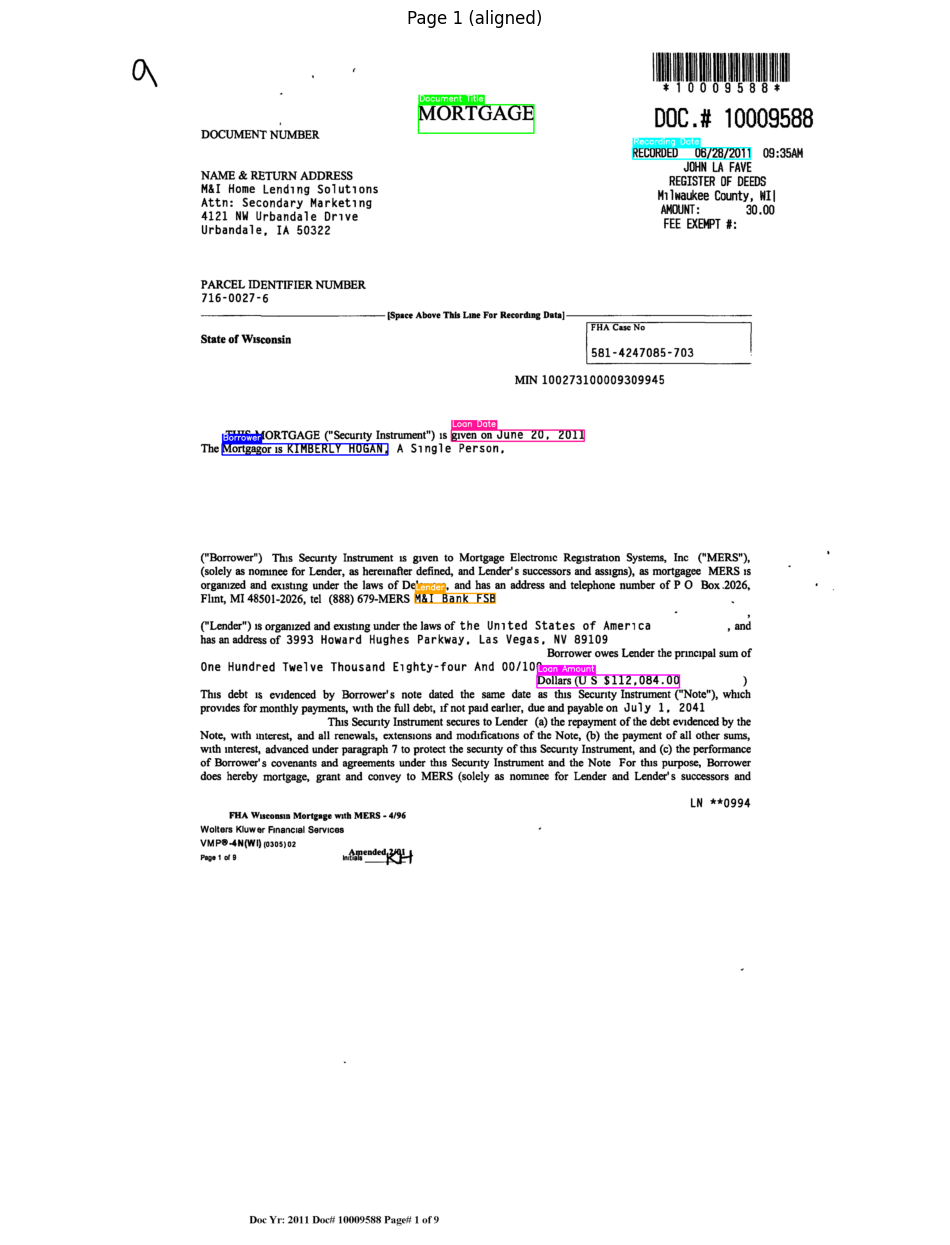

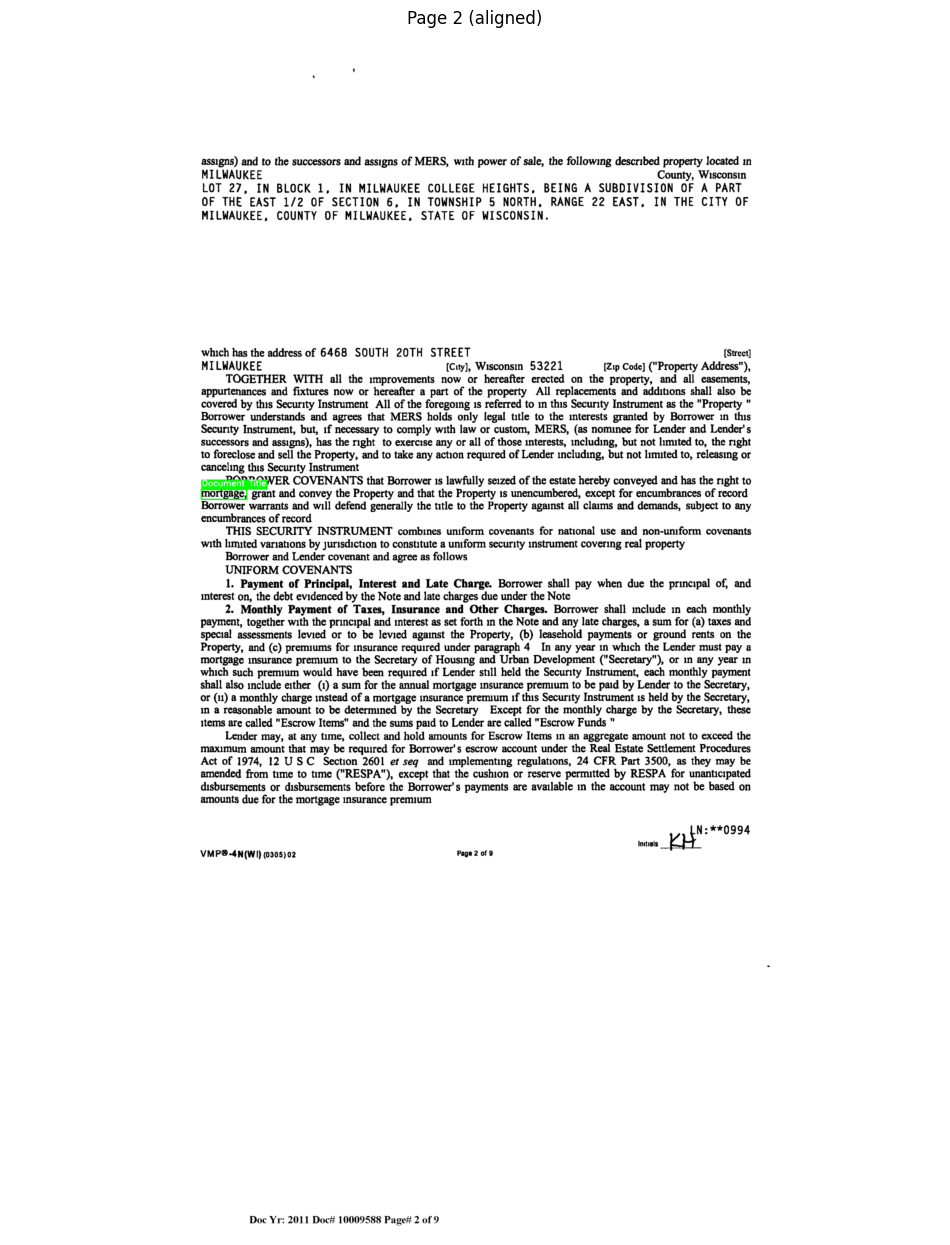

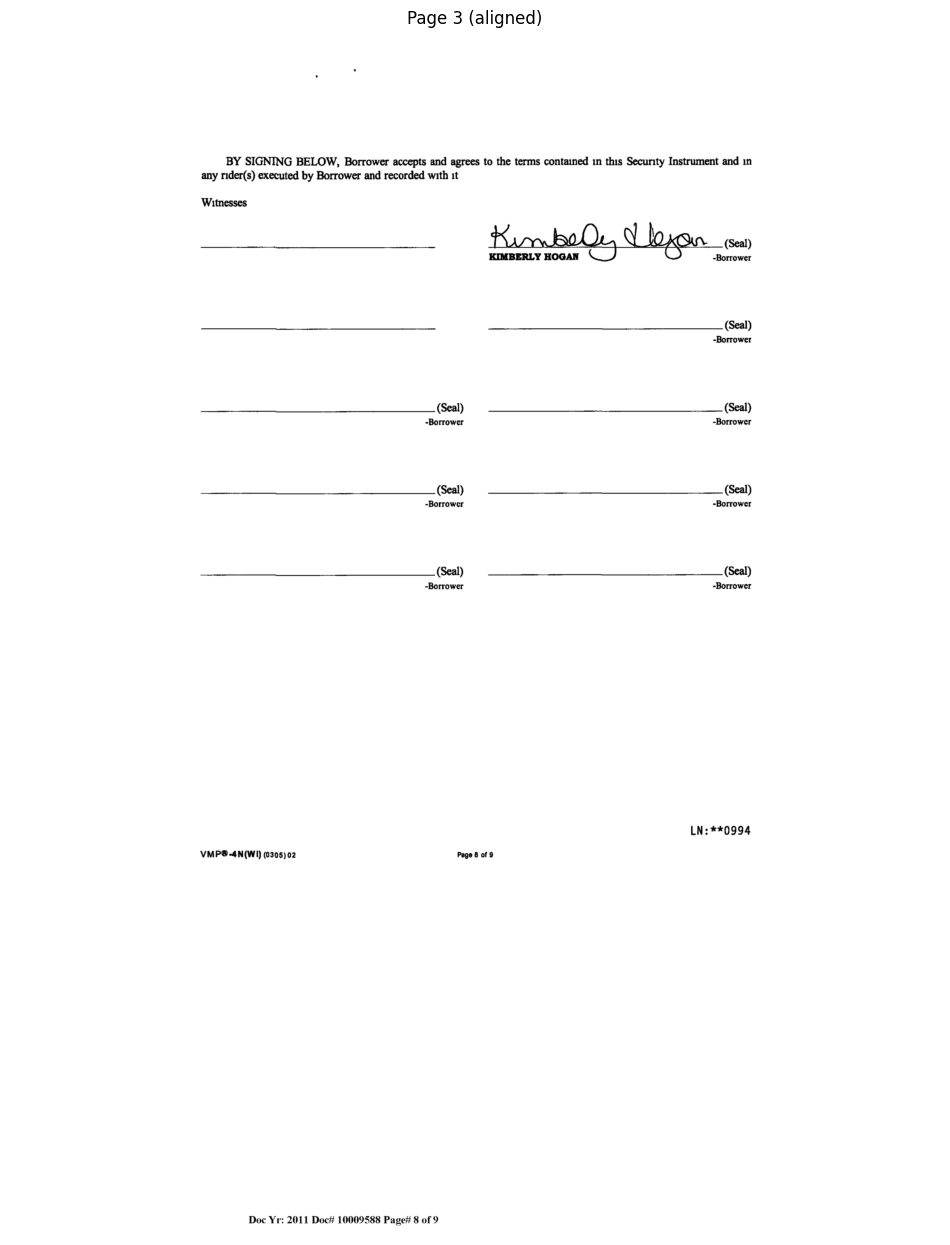

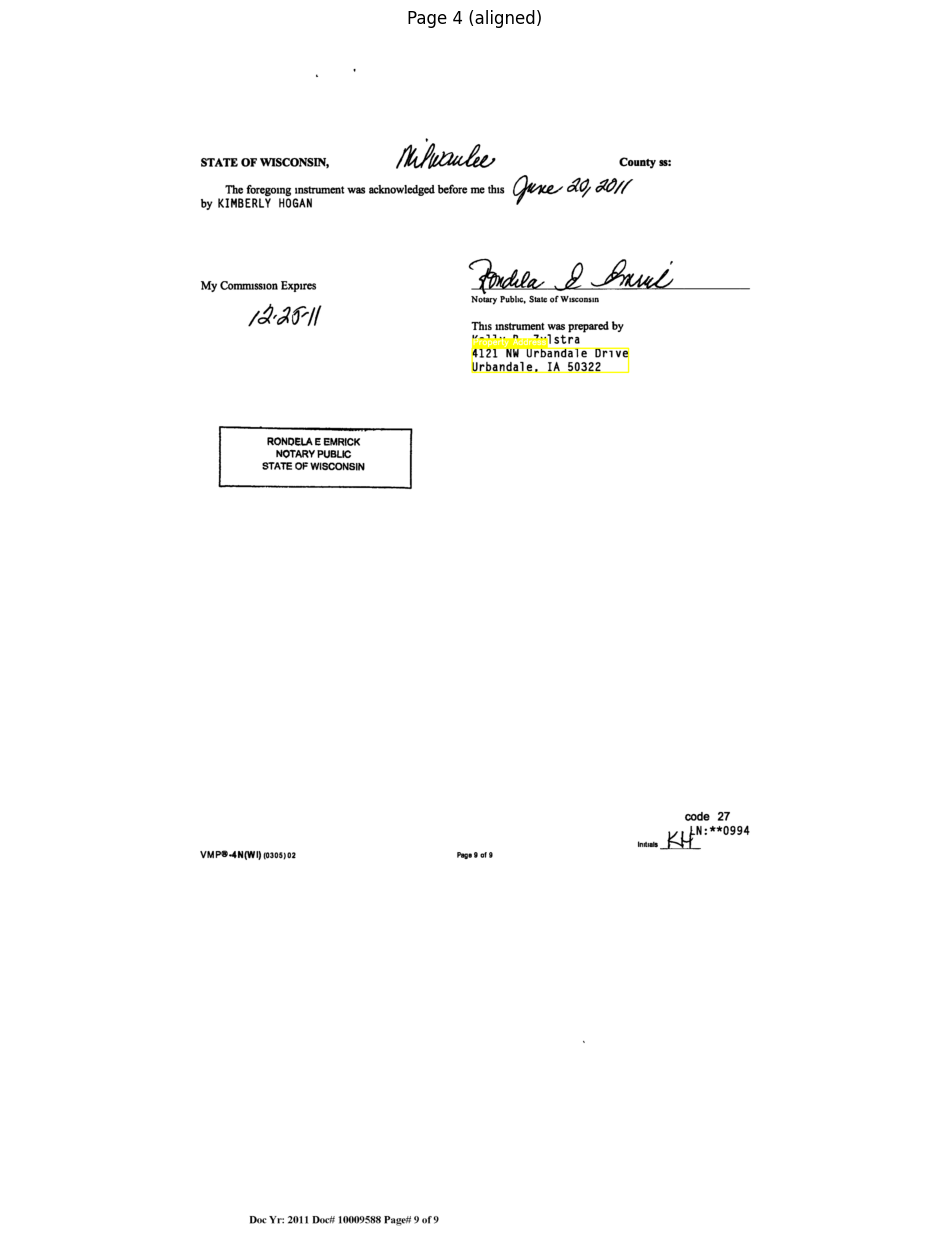

In [ ]:
# Import libraries
import cv2, matplotlib.pyplot as plt, os

# field -> BGR color
color_map = {
    "Document Title": (0, 255, 0),      # green
    "Borrower":       (255, 0, 0),      # blue
    "Lender":         (0, 165, 255),    # orange
    "Loan Amount":    (255, 0, 255),    # magenta
    "Recording Date": (255, 255, 0),    # cyan
    "Loan Date":      (147, 20, 255),   # purple
    "Property Address": (0, 255, 255),  # yellow
}

default_color = (0, 0, 255)

dpi_used = 400        # MUST match OCR render DPI
upsample_fx = 1.5     # MUST match my OCR resize factor

save_dir = "annotated_pages_aligned"
os.makedirs(save_dir, exist_ok=True)

for page_num in range(1, len(doc)+1):
    # --- Render the page for DISPLAY (no OCR preprocessing)
    page = doc[page_num-1]
    pix_disp = page.get_pixmap(dpi=dpi_used, alpha=False)
    img_disp = np.frombuffer(pix_disp.samples, np.uint8).reshape(pix_disp.height, pix_disp.width, pix_disp.n)
    vis = cv2.cvtColor(img_disp, cv2.COLOR_RGB2BGR)

    # --- Recreate the OCR image size for this page to know its width/height ---
    # (Do the SAME preprocessing chain you used before, but we don't need the image itself.)
    # If you want to avoid recompute, store width/height of `scaled` per page during OCR.
    pix_ocr = page.get_pixmap(dpi=dpi_used, alpha=False)
    img_ocr = np.frombuffer(pix_ocr.samples, np.uint8).reshape(pix_ocr.height, pix_ocr.width, pix_ocr.n)
    gray = cv2.cvtColor(img_ocr, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(2.0,(8,8))
    eq = clahe.apply(gray)
    den = cv2.fastNlMeansDenoising(eq, None, h=10, templateWindowSize=7, searchWindowSize=21)
    scaled_ocr = cv2.resize(den, None, fx=upsample_fx, fy=upsample_fx, interpolation=cv2.INTER_CUBIC)

    # scaled_ocr is the exact canvas Tesseract saw; results[bbox] are in this coordinate space
    h_ocr, w_ocr = scaled_ocr.shape[:2]
    h_disp, w_disp = vis.shape[:2]

    # scale factors from OCR space -> display space
    sx = w_disp / float(w_ocr)
    sy = h_disp / float(h_ocr)

    # --- Draw boxes for all fields on this page, scaling coordinates ---
    for field, matches in results.items():
        color = color_map.get(field, default_color)
        for m in matches:
            if m.get("page") != page_num:
                continue
            bbox = m.get("bbox")
            if not bbox:
                continue
            x1,y1,x2,y2 = bbox
            # scale bbox to display image coordinates
            X1, Y1, X2, Y2 = int(round(x1*sx)), int(round(y1*sy)), int(round(x2*sx)), int(round(y2*sy))

            cv2.rectangle(vis, (X1,Y1), (X2,Y2), color, 3)
            label = field
            (tw, th), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)
            ty = Y1 - 10 if Y1 - 10 - th > 0 else Y1 + th + 10
            tx = X1
            cv2.rectangle(vis, (tx, ty - th - 4), (tx + tw + 6, ty + baseline), color, -1)
            cv2.putText(vis, label, (tx + 3, ty - 3), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2, cv2.LINE_AA)

    # Show & save the PDF with boundary boxes
    plt.figure(figsize=(12,16))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"Page {page_num} (aligned)")
    plt.axis("off")
    plt.show()

    cv2.imwrite(os.path.join(save_dir, f"page_{page_num:02d}_aligned.png"), vis)